## 分析A/B测试结果

我们设计项目的初衷是希望让它涵盖统计课程里所有的内容，所以项目会有难度。如果你进行不顺利，不用着急，你可以回顾以前课程中的内容，或者寻求帮助。如果你成功完成项目，代表你已掌握这部分内容。祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

A/B 测试是数据分析师和数据科学家需要经常完成的工作，非常重要。如果你在工作中有一些实践经验，那学习起来就会更加游刃有余。

本项目设定了一家电子商务网站运行 A/B 测试的情境。你的目标是通过这个项目来帮助公司分析和决定他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**注意，有些题目会提醒你先做课堂页面的测试问题，这些测试会提供答案，可以给你提供一些帮助。** 最后做完项目时记得检查，确保提交内容符合[审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 。

<a id='probability'></a>
#### I - 概率

先导入数据。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  你可以直接进行以下问题的回答，或者 **做教室里的测试 1** 。

a. 导入数据集，查看前几行数据：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查看数据集的行数。

In [3]:
df.shape[0]

294478

c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df.user_id.nunique()

290584

d. 转化用户的占比。

In [5]:
df.converted.mean()

0.11965919355605512

e. 请计算数据中 `new_page` 与 `treatment` 不匹配的次数。提示：在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [6]:
df.groupby(('group', 'landing_page'),as_index=False).count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


,group,landing_page,user_id,timestamp,converted
0,control,new_page,1928,1928,1928
1,control,old_page,145274,145274,145274
2,treatment,new_page,145311,145311,145311
3,treatment,old_page,1965,1965,1965


In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893


f. 是否有任何行空缺数值？

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是否接收到了新页面还是旧页面。如何处理这些行？你可以返回教室里的页面先做 **测试 2** 。  

a. 现在，参照测试2的答案去创建一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [9]:
df2 = df[((df.group == 'control')&(df.landing_page == 'old_page')|
          (df.group == 'treatment')&(df.landing_page == 'new_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 根据 **df2** 来回答以下问题，或者做教室里的 **测试3** 。

a.  **df2** 中的用户数量（不同的 **user_id**) ?

In [11]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？

In [12]:
df2[df2['user_id'].duplicated(keep=False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. 这个重复  **user_id** 的行信息是什么？

In [13]:
df2[df2.duplicated('user_id',False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除一行重复行，但仍然存储 dataframe 为 **df2**。

In [14]:
df2 = df2.drop(1899)

`4.` 使用优化过的 **df2** 来回答以下问题，或者做 **测试 4**。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

In [15]:
df2.converted.mean()

0.11959708724499628

b. `control` 组用户的转化率是多少？

In [16]:
obs_p_old = df2.query('group=="control"').converted.mean()
obs_p_old

0.1203863045004612

c. `treatment` 组用户的转化率是多少？

In [17]:
obs_p_new = df2.query('group=="treatment"').converted.mean()
obs_p_new

0.11880806551510564

d. 一个用户收到新页面的概率是多少？

In [18]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？

**在这里写出你的答案。**

##### 答：没有足够数据支持证明旧页面或者新页面可以带来更高转化率

<a id='ab_test'></a>
### II - A/B 测试

因为每个事件都对应有一个时间记录（time stamp 时间戳），所以技术上你可以实现每次观察都连续运行假设检验。

然而，问题的难点在于，什么时候停止你的试验：是在发现其中一组的试验效果足够好时立即停止？还是在这样的观察结果又持续发生了一段时间再停止？需要运行多长时间才能确认两个页面没有带来用户转化率的显著差异？

这些问题是 A/B 测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你需要根据我们提供的数据做出决策：你假设旧页面效果更佳，除非在一类错误在5%以内，新页面被证明更好。基于此，你的零假设和备择假设是什么？ 你可以用文字表述或用 **$p_{old}$** 与 **$p_{new}$** （即，旧页面转化率与新页面转化率）来陈述你的假设。

**在这里给出你的答案。**

零假设为旧页面的转化率不小于新页面的转化率→→ **$p_{old}$** ≥ **$p_{new}$**

备择假设为旧页面的转化率小于新页面的转化率→→ **$p_{old}$** ＜ **$p_{new}$**

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，我们还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。记住，每个页面的样本大小要与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>

使用下面的单元格提供这个模拟试验的内容。如果不太理解如何进行模拟，不要担心，你可以通过回答下面的问题来理清思路。同时，你可以在教室里的 **测试 5** 里验证你的答案是否正确。<br>

a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [19]:
null_p_new = df2.converted.mean()
null_p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

In [20]:
null_p_old = null_p_new
null_p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [21]:
n_new = df2.query('landing_page=="new_page"').shape[0]
n_new

145310

d.  $n_{old}$?是多少？

In [22]:
n_old = df2.query('landing_page=="old_page"').shape[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [23]:
random.seed(42)
new_page_converted = np.random.choice(2, n_new, p=[1-null_p_new,null_p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [24]:
random.seed(42)
old_page_converted = np.random.choice(2, n_old, p=[1-null_p_old,null_p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [25]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_diff = p_new - p_old
p_diff

-0.00043567638134013598

h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, n_new, p=[1-null_p_new,null_p_new])
    old_page_converted = np.random.choice(2, n_old, p=[1-null_p_old,null_p_old])
    p_new = new_page_converted.mean()
    p_old = old_page_converted.mean()
    p_diffs.append(p_new - p_old)
p_diffs = np.array(p_diffs)

i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

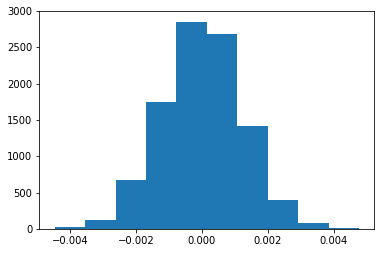

In [27]:
plt.hist(p_diffs);

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [28]:
obs_diff = obs_p_new - obs_p_old

(p_diffs>obs_diff).mean()

0.90269999999999995

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

**在这里给出你的答案。**


##### 答：这个值是P值，该数值为0.9027，较大，无法拒绝零假设。

### 思考：control组和treatment组的实验时间是否有较大出入？

In [29]:
df_time = df2.sort_values(by = ['group','timestamp'])
pd.to_datetime(df_time['timestamp'])
df_control_time = df_time[df_time['group']=='control']
df_treatment_time = df_time[df_time['group']=='treatment']

In [30]:
df_control_time.iloc[[0,-1]]

,user_id,timestamp,group,landing_page,converted
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
193652,920411,2017-01-24 13:41:54.460509,control,old_page,0


In [31]:
df_treatment_time.iloc[[0,-1]]

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
157787,843121,2017-01-24 13:41:44.097174,treatment,new_page,0


##### 两组测试时间均为22天，可以认定为几乎一致。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group=="control"').converted.sum()
convert_new = df2.query('group=="treatment"').converted.sum()
n_old = df2.query('group=="control"').shape[0]
n_new = df2.query('group=="treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. 现在使用 `stats.proportions_ztest` 来计算你的 z-score (什么是 [z-score](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)) 与 p-value。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 的资料可以提供额外信息。

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [34]:
from scipy.stats import norm
norm.cdf(z_score), norm.ppf(1-0.05)

(0.90505831275902449, 1.6448536269514722)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？

**在这里给出你的答案。**

##### 答：区别不大，从p-值来看，统计量有超过90%的可能来自零假设，

##### 从z-分数1.3110来看，小于1.6449的995%置信区间临界值，所以结果与j.与k.问题中一致：
**不能拒绝零假设**。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

##### 答: 逻辑回归，由于变量多为属性区分而不是数值大小，所以不适合使用线性回归进行分析。

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [35]:
df2 = df2.join(pd.get_dummies(df2['landing_page']), on=None, how='left')
df2['ab_page'] = df2['group'].map({'treatment':1,'control':0})
df2['intercept'] = 1


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [36]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        07:40:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

##### 答：p-值为0.190，因为逻辑回归模型下的零假设为ab_page因素与转化率不存在显著的转化差异，备择假设为ab_page因素与转化率存在显著的转化差异；

##### 而Part II中的p-值为0.9027，因为零假设与备择假设本身具有方向性，所以p-值的计算方式与逻辑回归模型不同。



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

##### 答：因为可能影响转化的因素有很多，对各类因素进行更全面且独立的分析有助于做出正确判断；
##### 但如果同时分析过多的因素互相关联，可能会出现多重共线性，会导致回归系数与预期关系反转以及不准确的假设检验结果。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [38]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
df3.isnull().sum()

user_id    0
country    0
dtype: int64

In [40]:
#不同国家的用户样本数量是否有较大差异？
df3['country'].value_counts()/df3['country'].count()

US    0.700723
UK    0.249381
CA    0.049896
Name: country, dtype: float64

##### 各国用户中，美国用户最多，占70%，英国用户占25%，加拿大用户约占5%。

In [41]:
df3 = df2.set_index('user_id').join(df3.set_index('user_id'),on='user_id',how='left')

In [42]:
df3 = df3.join(pd.get_dummies(df3['country']), on=None, how='left')
df3 = df3.drop('US', axis=1)
df3 = df3.reset_index()

In [43]:
#不同国家的用户收到新页面的概率是否有较大出入？
df3.groupby(['country'])['ab_page'].mean()

country
CA    0.503552
UK    0.498247
US    0.500459
Name: ab_page, dtype: float64

##### 不同国家用户收到新页面的概率在50%上下，没有过大出入。

In [44]:
#不同国家的用户接入不同页面后的转化率是否有较大出入？
df3.groupby(['country', 'ab_page'])['converted'].mean()

country  ab_page
CA       0          0.118783
         1          0.111902
UK       0          0.120022
         1          0.121171
US       0          0.120630
         1          0.118466
Name: converted, dtype: float64

##### 相同国家用户收到新旧页面的转化率偏差不大。

In [45]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA', 'UK']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        07:40:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

##### 答：从结果来看国家项p-值均大于0.05的通常 alpha 水平，说明国家项并不能体现对转化率有较大影响。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [46]:
df3['ab_CA'] = df3['ab_page'] * df3['CA']
df3['ab_UK'] = df3['ab_page'] * df3['UK']

In [47]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept', 'ab_page', 'CA', 'UK', 'ab_CA', 'ab_UK']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        07:40:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_CA         -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_UK          0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

##### 答：将国家项与页面相互作用后，p-值依然均大于0.05的通常 alpha 水平，结果对转化率影响依旧不大。

### 思考：时间项是否对页面转化率有所影响？

In [48]:
#根据 timestamp 列判断登入网站日期为工作日或周末，并创建虚拟变量
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df3['week'] = df3['timestamp'].dt.strftime(date_format='%w')
df3['week'] = df3['week'].astype(int)+1
df3['week'] = df3['week'].astype(str)
df3['week'] = df3['week'].replace(['6','7'], 'weekend')
df3['week'] = df3['week'].replace(['1', '2', '3', '4', '5'], 'weekday')
df3['weekday'] = pd.get_dummies(df3['week'])['weekday']

In [49]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept', 'ab_page', 'weekday']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               1.150e-05
Time:                        07:40:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2941
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9968      0.012   -161.480      0.000      -2.021      -1.973
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
weekday        0.0110      0.013      0.853      0.393      -0.014       0.036
==============================================================================
"""

##### 答：观察接入网站的时间是否为周末与页面转化率进行比较，p-值均大于0.05的通常 alpha 水平，说明时间项可能对转化率影响不大。

In [50]:
df3['ab_weekday'] = df3['ab_page'] * df3['weekday']

In [51]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept', 'ab_page', 'weekday', 'ab_weekday']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               1.376e-05
Time:                        07:40:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4028
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9903      0.015   -128.799      0.000      -2.021      -1.960
ab_page       -0.0280      0.022     -1.274      0.203      -0.071       0.015
weekday        0.0021      0.018      0.117      0.907      -0.033       0.038
ab_weekday     0.0178      0.026      0.693      0.488      -0.033       0.068
==============================================================================
"""

##### 答：将时间项与页面相互作用后，p-值依然均大于0.05的通常 alpha 水平，结果对转化率影响依旧不大。

In [53]:
#根据 timestamp 列判断登入网站时间为上午或下午，并创建虚拟变量
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df3['time'] = df3['timestamp'].dt.strftime(date_format='%p')
df3['time'] = df3['time'].astype(str)
df3['am'] = pd.get_dummies(df3['time'])['AM']

In [54]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept', 'ab_page', 'am']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.798e-05
Time:                        07:48:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.05097
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9771      0.010   -200.589      0.000      -1.996      -1.958
ab_page       -0.0150      0.011     -1.314      0.189      -0.037       0.007
am            -0.0235      0.011     -2.058      0.040      -0.046      -0.001
==============================================================================
"""

In [55]:
1/np.exp(-0.0235)

1.0237783007466292

##### 答：观察用户上午或下午接入网站与页面转化率进行比较，am项的p-值为0.04,小于0.05的通常 alpha 水平，说明上午接入的用户与转化率成负相关。

In [56]:
df3['ab_am'] = df3['ab_page'] * df3['am']

In [57]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept', 'ab_page', 'am', 'ab_am']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               4.462e-05
Time:                        07:48:38   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.02339
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9877      0.011   -174.352      0.000      -2.010      -1.965
ab_page        0.0063      0.016      0.391      0.696      -0.025       0.038
am            -0.0021      0.016     -0.132      0.895      -0.034       0.029
ab_am         -0.0430      0.023     -1.882      0.060      -0.088       0.002
==============================================================================
"""

##### 答：将时间项与页面相互作用后，p-值为0.06虽大于0.05的通常 alpha 水平，但较为接近，说明网页接入时间对于转化率有一定影响，晚上接入的用户转化率可能更高。

<a id='conclusions'></a>
## 总结
从目前收集的数据信息来看，新页面并不能有效提高转化率。

鉴于当前A/B测试进行时间为22天，或许更长时间的测试、让美国以外国家的用户参与更多测试机会，以及更多其他项目的数据信息将有助于做出有效判断。

思考：其他可能对转化率有影响的项目：用户接入页面时长，开放更多海外用户接入数据。

#### 有帮助的网页
[pandas删除多个条件的行][1]　　——删除重复ID行

[Jupyter Notebook各种使用方法记录][2]　　——更改markdown格文本内容格式

[Udacity数据分析（入门）-分析 A/B 测试结果][3]　　——参考了z-score及页面与国家/地区的相互作用等等，但参考跑偏了T_T，无意抄袭，抱歉抱歉……

[z-score分数讲解 google cache页面][4]　　——审阅老师提供的链接~感恩~！

[关于datetime功能的代码使用][5]，
[Python3 pandas库(25) 时间日期高效操作 .dt.][6]，
[Python3 pandas(19) 替换 replace()及部分替换][7]，

——想观察一下周末与工作日是否对页面转化率有影响，上面这三个网站给我提供了很大帮助



[1]: https://cloud.tencent.com/developer/ask/129021
[2]: http://www.yaozihao.cn/2017/04/18/python%c2%b7jupyter-notebook%e5%90%84%e7%a7%8d%e4%bd%bf%e7%94%a8%e6%96%b9%e6%b3%95%e8%ae%b0%e5%bd%95%c2%b7%e6%8c%81%e7%bb%ad%e6%9b%b4%e6%96%b0/
[3]: https://blog.csdn.net/u010606346/article/details/84197892
[4]: http://webcache.googleusercontent.com/search?q=cache:QeVFrwCTQL0J:knowledgetack.com/python/statsmodels/proportions_ztest/+&cd=1&hl=en&ct=clnk
[5]: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
[6]: https://zhuanlan.zhihu.com/p/31490318
[7]: https://zhuanlan.zhihu.com/p/30829387

感恩助教大大提供的点拨，发现第一次提交的内容里有好多钻牛角尖的内容……如果此次提交还有不妥内容，烦请审阅老师指出Thanks♪(･ω･)ﾉ